In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import data_reader, data_analyser, trajectory_plotter

dr = data_reader.DataReader()
exp_1, exp_2 = 'Exp 1', 'Exp 2'
choices_1, dynamics_1 = dr.get_data(path='C:/Users/Arkady/Google Drive/data/eyehandrdk/exp_1/processed/', rename_vars=True, IT_threshold=1.5)
choices_2, dynamics_2 = dr.get_data(path='C:/Users/Arkady/Google Drive/data/eyehandrdk/exp_2/processed/', rename_vars=True, IT_threshold=1.5)

# here we need to highlight the data by subj_id, and this is currently not possible in seaborn with multi-index dataframes
choices_1 = choices_1.reset_index()
choices_2 = choices_2.reset_index()

choices = choices_2

<a name="ID_lag"></a>
# Hand-eye lag at initial decision
Now, let's look at the hand-eye lag at initial decision:
>lag at initiation = hand IT - eye IT

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


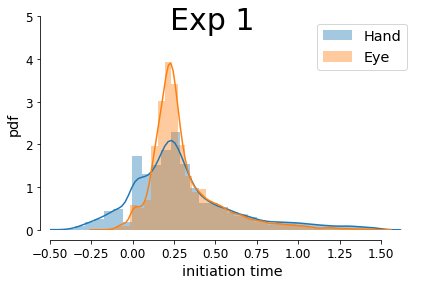

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


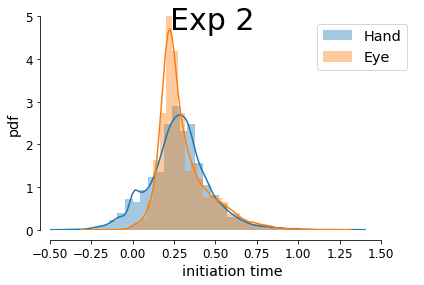

In [2]:
def plot_IT_dist(choices, exp):
    plt.figure()
    ax = sns.distplot(choices['hand IT'], bins=40, label='Hand')
    sns.distplot(choices.loc[~choices['eye IT'].isnull(), 'eye IT'], bins=40, label='Eye', ax=ax)
    ax.set_xlabel('initiation time')
    ax.set_ylabel('pdf')
    ax.set_xlim(-0.5, 1.7)
    ax.set_ylim(0, 5)
    sns.despine(ax=ax, trim=True, offset=10)
    plt.suptitle(exp, fontsize=30)
    plt.legend()
    plt.savefig(('figures/IT_dist_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')

plot_IT_dist(choices_1, exp_1)
plot_IT_dist(choices_2, exp_2)

In [3]:
choices = choices_1
len(choices[choices['hand IT'] < choices['eye IT']])/len(choices)

0.5717251174478313

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


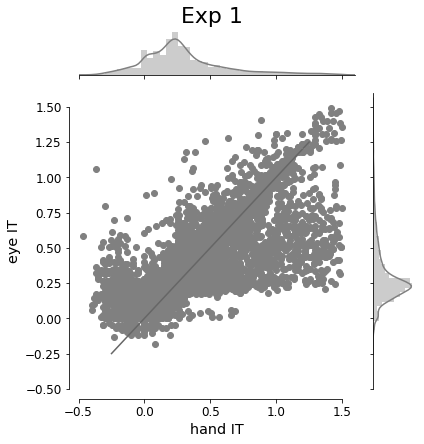

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


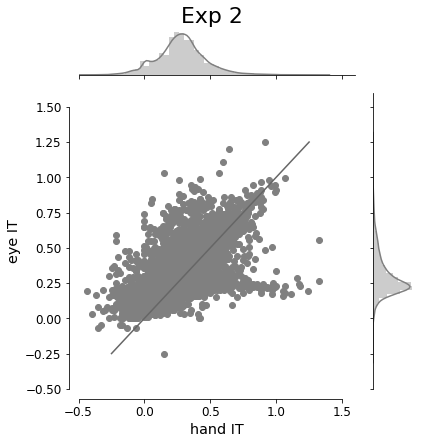

In [4]:
def plot_joint(choices, exp, x, y, stat_func=None):
    g = sns.jointplot(data=choices, x=x, y=y, stat_func=stat_func, color='0.5',
                      marginal_kws=dict(kde=True, hist=True), xlim=(-0.5,1.6), ylim=(-0.5,1.6))
    x_grid = np.linspace(-0.25, 1.25, 10)
    g.ax_joint.plot(x_grid,x_grid, color='0.4')
#     g.ax_joint.set_yticks(g.ax_joint.get_xticks())
    sns.despine(ax=g.ax_joint, trim=True, offset=10)
    plt.suptitle(exp, fontsize=22, y=1.02)
    g.savefig(('figures/joint_%s_vs_%s_%s.png' % (x,y,exp)).replace(' ', '_'))
    
plot_joint(choices_1, exp_1, x='hand IT', y='eye IT')
plot_joint(choices_2, exp_2, x='hand IT', y='eye IT')

Interestingly, ID lag is highly correlated with mouse IT but not with eye IT in Exp 1, so the lag is mainly determined by mouse response. However, in Exp 2, the lag depends on eye IT as well: correlation between the lag and mouse_IT is much weaker in Exp 2.

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is d

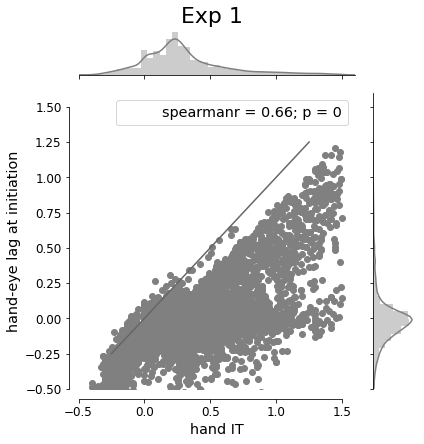

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


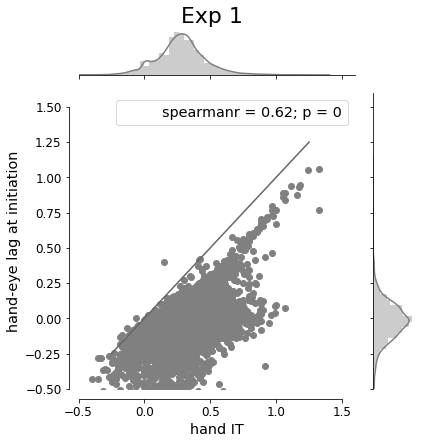

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


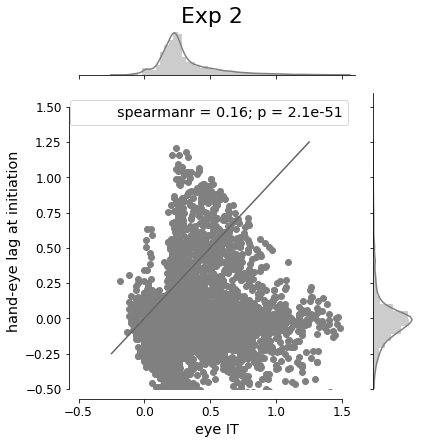

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


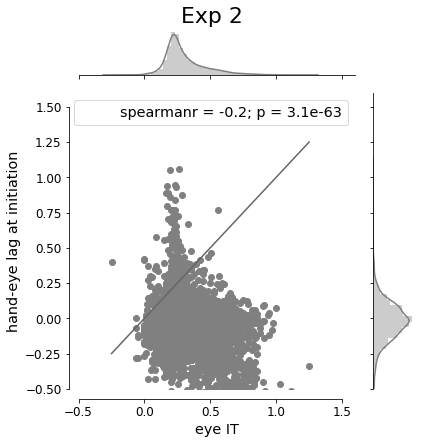

In [5]:
from scipy.stats import spearmanr

plot_joint(choices=choices_1[~(choices_1['eye IT'].isnull())], exp=exp_1, 
           x='hand IT', y='hand-eye lag at initiation', stat_func=spearmanr)
plot_joint(choices=choices_2[~(choices_2['eye IT'].isnull())], exp=exp_1, 
           x='hand IT', y='hand-eye lag at initiation', stat_func=spearmanr)
plot_joint(choices=choices_1[~(choices_1['eye IT'].isnull())], exp=exp_2, 
           x='eye IT', y='hand-eye lag at initiation', stat_func=spearmanr)
plot_joint(choices=choices_2[~(choices_2['eye IT'].isnull())], exp=exp_2, 
           x='eye IT', y='hand-eye lag at initiation', stat_func=spearmanr)

In Exp 1, dependence of ID lag on coherence basically follows that of mouse IT, with one participant having substantially larger lag than the others due to late mouse movements.

Importing Jupyter notebook from initiation_times.ipynb


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


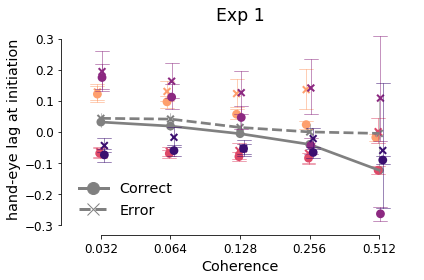

In [6]:
import nbimporter
from initiation_times import plot_var_vs_coherence

plot_var_vs_coherence(choices_1, exp_1, var='hand-eye lag at initiation', estimator=np.nanmean)

However, if we account for individual differences in scale of the lag, the general pattern becomes very clear

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


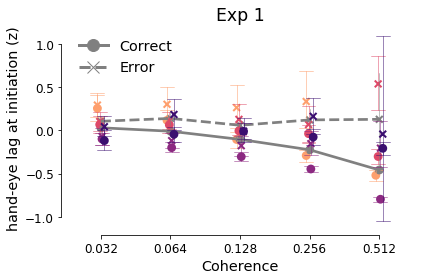

In [7]:
plot_var_vs_coherence(choices_1, exp_1, var='hand-eye lag at initiation (z)', estimator=np.nanmean)

Next, let's look at Exp 2 ID lag.

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


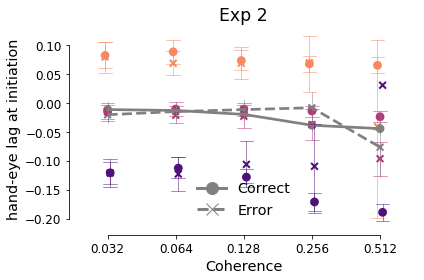

In [8]:
plot_var_vs_coherence(choices_2, exp_2, var='hand-eye lag at initiation', estimator=np.nanmean)

Here the variability is even higher. The three participants have very different lags, one has positive lag, one has negative lag, and another one's lag is around 0. It doesn't become clearer when z-scores are used.

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


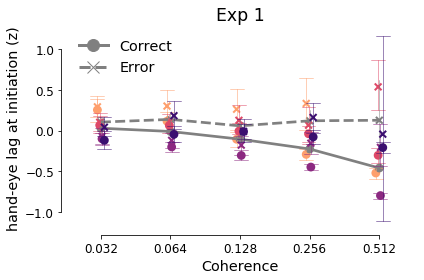

In [9]:
plot_var_vs_coherence(choices_1, exp_1, var='hand-eye lag at initiation (z)', estimator=np.nanmean)

# Eye-hand lag at initial decision

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:2612: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:2612: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users

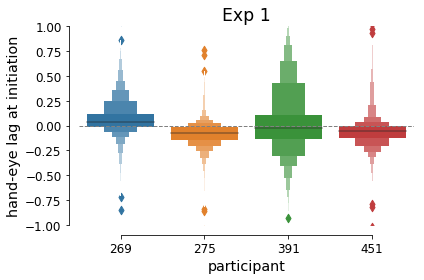

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


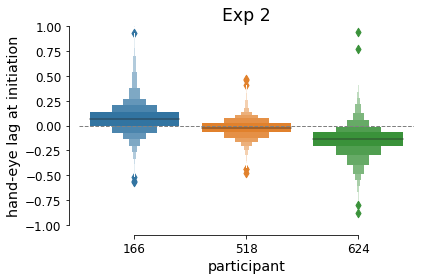

In [10]:
def plot_lag_by_subj(choices, exp):
    plt.figure()
    ax = sns.lvplot(data=choices, x='subj_id', y='hand-eye lag at initiation')
    ax.set_xlabel('participant')
    ax.axhline(0.0, color='grey', ls='--', lw=1)
    ax.set_ylim((-1., 1.))
    plt.title(exp)
    sns.despine(trim=True, offset=10)
    plt.savefig(('figures/lag_by_subj_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')
    
plot_lag_by_subj(choices_1, exp_1)
plot_lag_by_subj(choices_2, exp_2)

In [11]:
choices_2.loc[~np.isnan(choices_2['hand-eye lag at initiation']), 'hand-eye lag at initiation'].describe()

count    6959.000000
mean       -0.023866
std         0.162342
min        -0.878600
25%        -0.111100
50%        -0.020200
75%         0.070500
max         1.061000
Name: hand-eye lag at initiation, dtype: float64

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Exp 1 ID lag = 0.026 s  diff from 0: t=11.649422, p=0.0000000000
Exp 2 ID lag = -0.007 s  diff from 0: t=-3.868385, p=0.0001106401


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


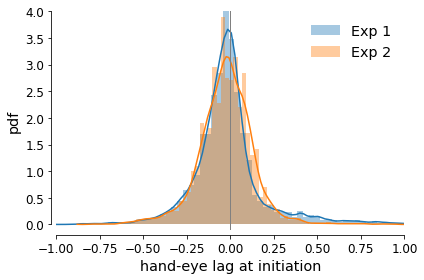

In [12]:
from scipy.stats import ttest_1samp

def ID_lag_ttest_one_sample(choices):
    t, p = ttest_1samp(choices.loc[(choices['hand-eye lag at initiation'].notnull()), 'hand-eye lag at initiation'], 0)
    return (t, p)

def print_ID_lag_ttest(choices, exp):
    print('%s ID lag = %.3f s  diff from 0: t=%f, p=%.10f' % ((exp, choices['hand-eye lag at initiation'].mean())
                                                              + ID_lag_ttest_one_sample(choices)))
def plot_ID_lag_dist(choices_1, choices_2):
    ax = sns.distplot(choices_1.loc[~np.isnan(choices_1['hand-eye lag at initiation']), 'hand-eye lag at initiation'], 
                      label='Exp 1', bins=80, kde=True, kde_kws={'cut': 0})    
    ax = sns.distplot(choices_2.loc[~np.isnan(choices_2['hand-eye lag at initiation']), 'hand-eye lag at initiation'],
                      label='Exp 2', bins=80, kde=True, kde_kws={'cut': 0}, ax=ax)
    ax.set_xlim((-1.,1.))
    ax.set_ylim((-0.1,4))
    ax.set_xlabel('hand-eye lag at initiation')
    ax.set_ylabel('pdf') 
    plt.axvline(0.0, lw=1.0, color='gray')
    plt.legend(frameon=False)
    sns.despine(ax=ax, trim=True, offset=5)
    plt.savefig('figures/ID_lag', bbox_inches='tight')    
    
plot_ID_lag_dist(choices_1, choices_2)

print_ID_lag_ttest(choices_1[choices_1['hand IT']>0], exp_1)
print_ID_lag_ttest(choices_2[choices_2['hand IT']>0], exp_2)

# print_ID_lag_ttest(choices_1, exp_1)
# print_ID_lag_ttest(choices_2, exp_2)


# print('ID lag diff from 0, Exp. 2 t=%f, p=%.10f' % ID_lag_ttest_one_sample(choices_2))

In [13]:
choices_2['hand-eye lag at initiation'].mode()

0    0.0
dtype: float64

# Hand-eye lag at CoM decision

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:2612: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will b

<Figure size 432x288 with 0 Axes>

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


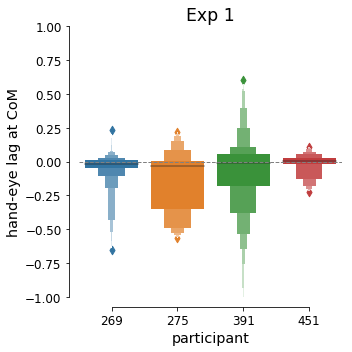

<Figure size 432x288 with 0 Axes>

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


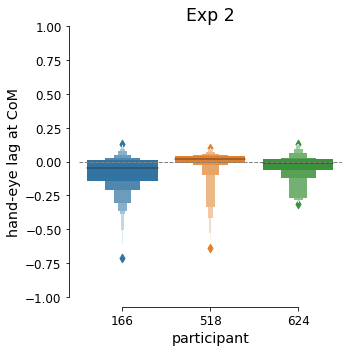

In [14]:
def plot_com_lag_by_subj(choices, exp):
    plt.figure()
#     ax = sns.swarmplot(data=choices, x='subj_id', y='com_lag')
#     ax.set_ylim((-1.0, 0.5))
    fig = sns.factorplot(data=choices, x='subj_id', y='com_lag', kind='lv')
    ax = fig.axes[0][0]
    ax.set_xlabel('participant')
    ax.set_ylabel('hand-eye lag at CoM')
    ax.set_ylim((-1.0, 1.))
    ax.axhline(0.0, color='grey', ls='--', lw=1)
    sns.despine(trim=True, offset=10)
    plt.title(exp)
#     ax.axhline(0.0, color='grey', ls='--', lw=1)
    plt.savefig(('figures/com_lag_by_subj_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')
    
plot_com_lag_by_subj(choices_1, exp_1)
plot_com_lag_by_subj(choices_2, exp_2)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


CoM hand-eye lag in Exp 1: -0.057s, Exp. 2: -0.046s
CoM lag diff from 0, Exp. 1 p-value: 0.000056, Exp. 2: 0.0000001815


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


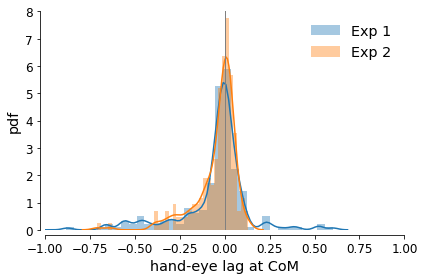

In [15]:
def com_lag_ttest_one_sample(choices):
    t, p = ttest_1samp(choices.com_lag[(choices.com_lag.notnull())], 0)
    return (t, p)

def plot_com_lag_dist(choices_1, choices_2):
    ax = sns.distplot(choices_1.loc[~np.isnan(choices_1.com_lag), 'com_lag'], label='Exp 1', bins=40)    
    ax = sns.distplot(choices_2.loc[~np.isnan(choices_2.com_lag), 'com_lag'], label='Exp 2', bins=40, ax=ax)
    ax.set_xlim((-1,1))
    ax.set_ylim((0,8))
    plt.axvline(0.0, lw=1.0, color='gray')
    ax.set_xlabel('hand-eye lag at CoM')
    ax.set_ylabel('pdf')    
    plt.legend(frameon=False)
    sns.despine(ax=ax, trim=True, offset=5)
    plt.savefig('figures/com_lag', bbox_inches='tight')

plot_com_lag_dist(choices_1, choices_2)
print('CoM hand-eye lag in Exp 1: %.3fs, Exp. 2: %.3fs' % (choices_1.com_lag.mean(), 
                                                       choices_2.com_lag.mean()))
print('CoM lag diff from 0, Exp. 1 p-value: %f, Exp. 2: %.10f' % (com_lag_ttest_one_sample(choices_1)[1], 
                                                      com_lag_ttest_one_sample(choices_2)[1]))


We can also look at the lags separately for early and late changes-of-mind:

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes th

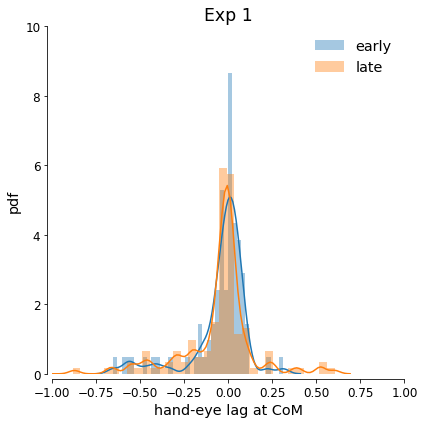

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


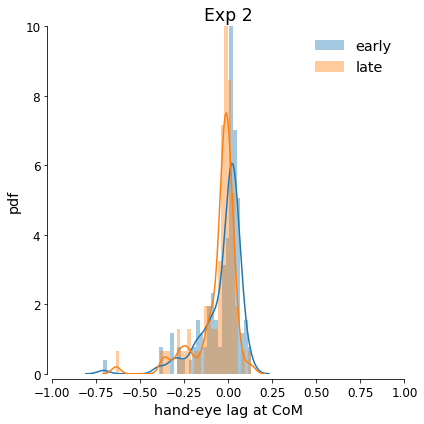

In [16]:
def plot_com_lag_dist_by_midline_d_y(choices, exp):    
#     choices['com_type'] = pd.cut(choices.midline_d_y, bins=[0, 700, 1080], labels=['early', 'late'])
    g = sns.FacetGrid(choices, hue='com_type', size=6, hue_order=['early', 'late'], xlim=(-1,1), ylim=(0,10))
    g = g.map(sns.distplot, 'com_lag', bins=40)
    g.set_axis_labels('hand-eye lag at CoM', 'pdf')
    plt.legend(frameon=False)
    g.despine(trim=True, offset=5)
    plt.title(exp)
    plt.savefig('figures/com_lag_by_com_type_%s' % (exp), bbox_inches='tight')

plot_com_lag_dist_by_midline_d_y(choices_1[choices_1.is_com], exp_1)
plot_com_lag_dist_by_midline_d_y(choices_2[choices_2.is_com], exp_2)

It seems that in late CoMs, the eye lags behind the hand more than in early CoMs. The difference is not statistically significant though.

In [17]:
from scipy.stats import ttest_ind

def pooled_sd(s1, s2):
    return np.sqrt(((len(s1)-1)*s1.var()+(len(s2)-1)*s2.var())/(len(s1)+len(s2)-2))

def com_lag_late_early_ttest(choices):
    t, p = ttest_ind(choices.loc[((choices.is_com) & (choices.com_type=='early') & (~choices.com_lag.isnull())), 'com_lag'], 
                    choices.loc[((choices.is_com) & (choices.com_type=='late') & (~choices.com_lag.isnull())), 'com_lag'], equal_var=False)
    return (t, p)

print('Exp 1, p-value: %f' % (com_lag_late_early_ttest(choices_1)[1]))
print('Exp 2, p-value: %f' % (com_lag_late_early_ttest(choices_2)[1]))


Exp 1, p-value: 0.548279
Exp 2, p-value: 0.159783
